<a href="https://colab.research.google.com/github/meinfosac/TelecomXII/blob/main/telecomX2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 📦 Extracción y desanidado

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos desde JSON de GitHub
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"
df = pd.read_json(url)

# Expandir diccionarios anidados
customer_df = pd.json_normalize(df['customer'])
phone_df    = pd.json_normalize(df['phone'])
internet_df = pd.json_normalize(df['internet'])
account_df  = pd.json_normalize(df['account'])

df_full = pd.concat([df[['customerID', 'Churn']], customer_df, phone_df, internet_df, account_df], axis=1)


In [ ]:
# Convertir cargos a numérico
df_full['Charges.Monthly'] = pd.to_numeric(df_full['Charges.Monthly'], errors='coerce')
df_full['Charges.Total']   = pd.to_numeric(df_full['Charges.Total'], errors='coerce')

# Eliminar filas con nulos críticos
df_full = df_full.dropna(subset=['Charges.Monthly', 'Charges.Total', 'tenure'])

# Estandarizar variables Sí/No
yes_no_cols = [
    'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]
for col in yes_no_cols:
    if col in df_full.columns:
        df_full[col] = df_full[col].map({'Yes': 1, 'No': 0, 'Sí': 1, 'No': 0})

df_full['Churn'] = df_full['Churn'].map({'Yes': 1, 'No': 0, 'Sí': 1, 'No': 0})

# Crear columna 'Cuentas_Diarias'
df_full['Cuentas_Diarias'] = df_full['Charges.Monthly'] / 30

# Eliminar duplicados
df_full = df_full.drop_duplicates()

# Eliminar columnas irrelevantes
df_full = df_full.drop(columns=['customerID'], errors='ignore')


In [ ]:
# Detección automática de categóricas no binarias
cat_cols = df_full.select_dtypes(include=['object']).columns.tolist()
cat_cols = [c for c in cat_cols if c != 'Churn']  # Excluir objetivo

# One-hot encoding
df_model = pd.get_dummies(df_full, columns=cat_cols, drop_first=True)


In [ ]:
from sklearn.preprocessing import StandardScaler

num_cols = ['tenure', 'Charges.Monthly', 'Charges.Total', 'Cuentas_Diarias']
scaler = StandardScaler()
df_model[num_cols] = scaler.fit_transform(df_model[num_cols])


In [ ]:
from sklearn.model_selection import train_test_split

# Drop rows with NaN in 'Churn' column
# Elimina filas donde Churn es NaN (antes de separar en X/y)
df_model = df_model.dropna(subset=['Churn'])

# Ahora sí puedes seguir:
X = df_model.drop(columns=['Churn'])
y = df_model['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

In [ ]:
# ...todo tu preprocesamiento...
from sklearn.model_selection import train_test_split

X = df_model.drop(columns=['Churn'])
y = df_model['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# --- IMPUTACIÓN DE NULOS AQUÍ ---
from sklearn.impute import SimpleImputer
import numpy as np

num_cols = X_train.select_dtypes(include=[np.number]).columns
imp = SimpleImputer(strategy="mean")
X_train[num_cols] = imp.fit_transform(X_train[num_cols])
X_test[num_cols]  = imp.transform(X_test[num_cols])

cat_cols = X_train.select_dtypes(include=['uint8', 'int64', 'bool']).columns
X_train[cat_cols] = X_train[cat_cols].fillna(0)
X_test[cat_cols] = X_test[cat_cols].fillna(0)

X_train = X_train.dropna()
X_test = X_test.dropna()
y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

# --- ENTRENAMIENTO DE MODELOS ---
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)


Árbol de Decisión
Accuracy: 0.782707622298066
              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      1291
         1.0       0.58      0.64      0.61       467

    accuracy                           0.78      1758
   macro avg       0.72      0.74      0.73      1758
weighted avg       0.79      0.78      0.79      1758

Regresión Logística
Accuracy: 0.7974971558589306
              precision    recall  f1-score   support

         0.0       0.84      0.89      0.87      1291
         1.0       0.64      0.53      0.58       467

    accuracy                           0.80      1758
   macro avg       0.74      0.71      0.72      1758
weighted avg       0.79      0.80      0.79      1758



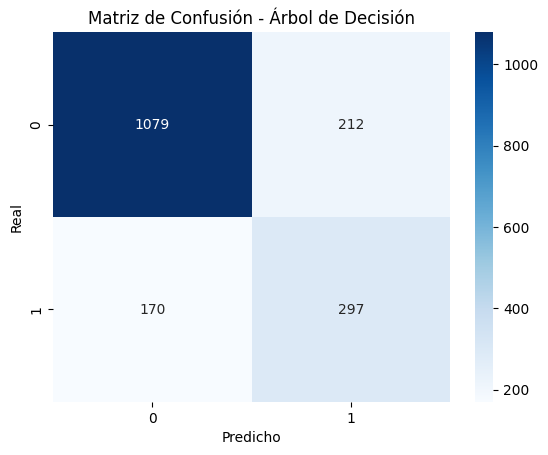

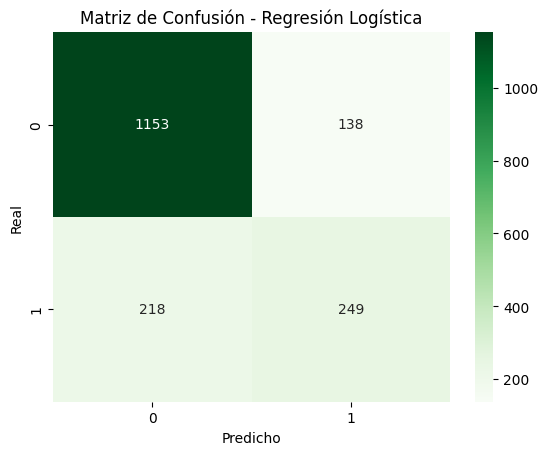

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Árbol de Decisión")
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

print("Regresión Logística")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

# Matriz de confusión árbol
cm_tree = confusion_matrix(y_test, y_pred_tree)
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Árbol de Decisión")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# Matriz de confusión regresión logística
cm_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Greens')
plt.title("Matriz de Confusión - Regresión Logística")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()


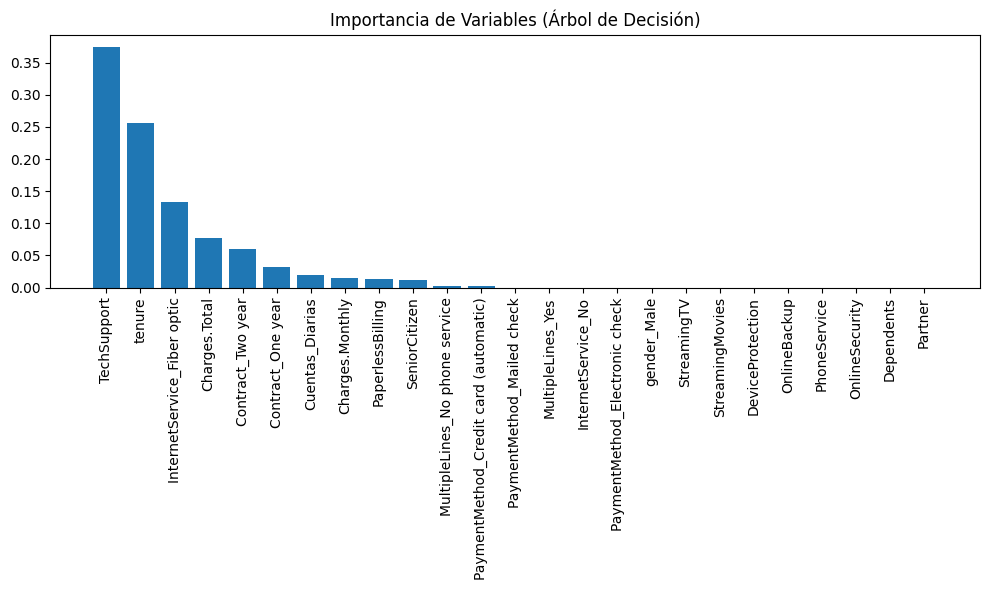

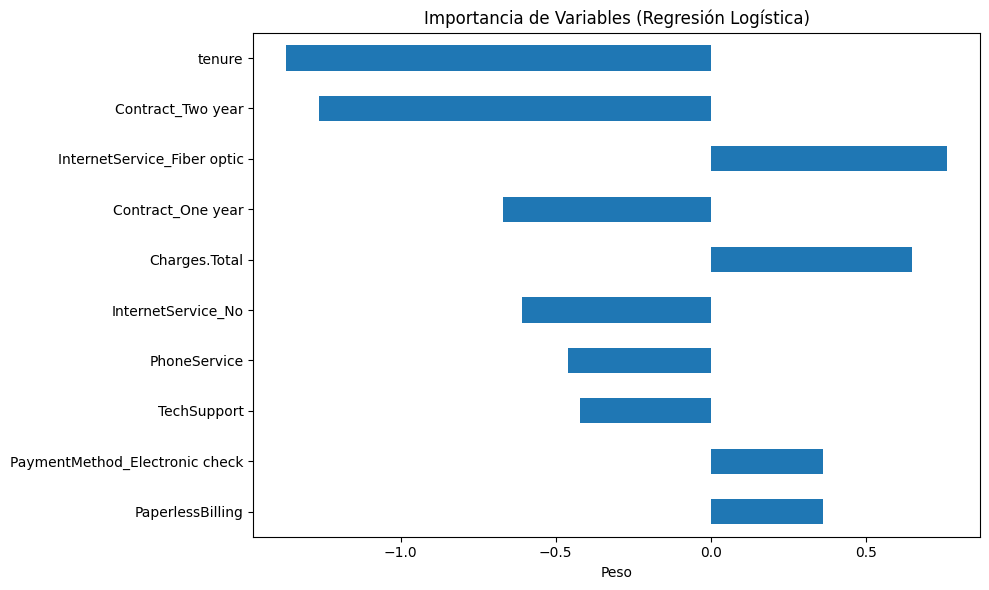

In [ ]:
import numpy as np

# Árbol de Decisión
importances = tree.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title('Importancia de Variables (Árbol de Decisión)')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Regresión Logística
coef = pd.Series(logreg.coef_[0], index=X_train.columns)
coef = coef.sort_values(key=abs, ascending=False)
plt.figure(figsize=(10,6))
coef.head(10).plot(kind='barh')
plt.title('Importancia de Variables (Regresión Logística)')
plt.xlabel('Peso')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
from IPython.display import Markdown

Markdown("""
## Conclusión Estratégica

Los modelos desarrollados permiten predecir con buena precisión qué clientes tienen mayor riesgo de cancelar el servicio.
Las variables más influyentes son: tipo de contrato, tenure, método de pago electrónico y monto mensual.
Se recomienda a Telecom X enfocar sus estrategias de retención en los clientes con contratos mes a mes, baja antigüedad y bajo gasto, así como revisar procesos asociados a los métodos de pago electrónicos.
""")



## Conclusión Estratégica

Los modelos desarrollados permiten predecir con buena precisión qué clientes tienen mayor riesgo de cancelar el servicio. 
Las variables más influyentes son: tipo de contrato, tenure, método de pago electrónico y monto mensual. 
Se recomienda a Telecom X enfocar sus estrategias de retención en los clientes con contratos mes a mes, baja antigüedad y bajo gasto, así como revisar procesos asociados a los métodos de pago electrónicos.
